# Ensemble

In [1]:
import numpy as np
import csv
import pandas as pd

from collections import Counter
from numpy import linalg as LA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
with open("/content/drive/MyDrive/CIn/Mestrado/2021.1/Aprendizagem de Máquina/Projeto - Francisco/yeast.data") as input_file:
   lines = input_file.readlines()
   newLines = []
   for line in lines:
      newLine = line.strip().split()
      newLines.append(newLine)

with open("/content/drive/MyDrive/CIn/Mestrado/2021.1/Aprendizagem de Máquina/Projeto - Francisco/yeast.csv", 'w') as test_file:
   file_writer = csv.writer(test_file)
   file_writer.writerows(newLines)

In [3]:
# reading csv files
data =  pd.read_csv("/content/drive/MyDrive/CIn/Mestrado/2021.1/Aprendizagem de Máquina/Projeto - Francisco/yeast.csv",
                    names=["sequence_name", "mcg", "gvh", "alm", "mit", "erl", "pox", "vac", "nuc", "protein_local"])
print(data)

     sequence_name   mcg   gvh   alm   mit  erl  pox   vac   nuc protein_local
0       ADT1_YEAST  0.58  0.61  0.47  0.13  0.5  0.0  0.48  0.22           MIT
1       ADT2_YEAST  0.43  0.67  0.48  0.27  0.5  0.0  0.53  0.22           MIT
2       ADT3_YEAST  0.64  0.62  0.49  0.15  0.5  0.0  0.53  0.22           MIT
3       AAR2_YEAST  0.58  0.44  0.57  0.13  0.5  0.0  0.54  0.22           NUC
4       AATM_YEAST  0.42  0.44  0.48  0.54  0.5  0.0  0.48  0.22           MIT
...            ...   ...   ...   ...   ...  ...  ...   ...   ...           ...
1479    YUR1_YEAST  0.81  0.62  0.43  0.17  0.5  0.0  0.53  0.22           ME2
1480    ZIP1_YEAST  0.47  0.43  0.61  0.40  0.5  0.0  0.48  0.47           NUC
1481    ZNRP_YEAST  0.67  0.57  0.36  0.19  0.5  0.0  0.56  0.22           ME2
1482    ZUO1_YEAST  0.43  0.40  0.60  0.16  0.5  0.0  0.53  0.39           NUC
1483    G6PD_YEAST  0.65  0.54  0.54  0.13  0.5  0.0  0.53  0.22           CYT

[1484 rows x 10 columns]


In [4]:
X = data.iloc[:, 1:9].values
y = data.iloc[:, 9].values

# Baysean Gaussian Classifier

In [5]:
def probability_priori(y):
  """return a list with each priori probability"""

  pr_pb = Counter(y)

  total = sum(pr_pb.values(), 0.0)

  for key in pr_pb:
    pr_pb[key] /= total  

  return pr_pb

def mi(X,y):

  y = np.expand_dims(y, axis=1)

  concat = np.hstack((X,y))

  ids=np.unique(concat[:,-1]) #array of unique ids

  pos_mean=[(i, np.mean(concat[concat[:,-1]==i, 0:-1], axis=0)) for i in ids]

  return pos_mean,concat

def sigma_square(X,y):

  mean_vector,concat = mi(X,y)
  classes = np.unique(y)
  
  mean_vector = dict(mean_vector)

  sigma_square_val = []

  for i in classes:
    mean = mean_vector[i]

    input_values = concat[concat[:,-1]==i, 0:-1]

    sub = input_values - mean

    d = len(sub[0])
    n = len(sub)

    sigma_square_val.append([i,LA.norm(sub)**2/(d*n)])

  return sigma_square_val

def sigma_matrix(X,y):
  """docstring"""

  lst = sigma_square(X,y)

  sigma_matrix_val = []

  for n,i in enumerate(lst):

    lst[n][1]

    diag = np.zeros((8, 8), float)
    np.fill_diagonal(diag, lst[n][1])

    sigma_matrix_val.append(diag)

  return np.array(sigma_matrix_val)

def probability_posteriori(class_name,classes,x,mean,sigma_matrix_values):

  d = sigma_matrix_values.shape[1]

  i = classes.index(class_name)

  posteriori = (1/(((2*np.pi)**(d/2))*np.sqrt(np.linalg.det(sigma_matrix_values[i]))))*np.exp(-0.5*(np.matmul(np.matmul(((x - mean).transpose()),(np.linalg.inv(sigma_matrix_values[i]))),x - mean)))

  return posteriori

def baysean_classifier(x_i,X,y):

  pp = probability_priori(y)
  mean_vector,concat = mi(X,y)
  matrix = sigma_matrix(X,y)
  classes = [mean_vector[n][0] for n,i in enumerate(mean_vector)]
  mean_vector = dict(mean_vector)

  classification_bg = []

  for x in x_i:

    probs = []

    for n,i in enumerate(classes):
      den = 0
      mean = mean_vector[i]
      for k,j in enumerate(classes):
        mean_den = mean_vector[j]
        den += pp[classes[k]]*probability_posteriori(j,classes,x,mean_den,matrix)

      num = pp[classes[n]]*probability_posteriori(i,classes,x,mean,matrix)
      probs.append(num/den)

    classification_bg.append(classes[probs.index(max(probs))])

  return classification_bg

In [6]:
#x = np.array([0.58, 0.61, 0.47, 0.13, 0.5, 0.0, 0.48, 0.22])
%%time
train_predict = baysean_classifier(X[0:],X,y)

x = train_predict
y_train = data.iloc[:, 9].values

print(sum([1 for n,i in enumerate(y_train) if x[n] == i])/len(x))

0.5680592991913747
CPU times: user 13.3 s, sys: 11.2 s, total: 24.5 s
Wall time: 12.6 s


# KNN

In [7]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y)

predict = neigh.predict(X)

accuracy_score(y,predict)

0.7311320754716981

# Parzen

In [8]:
def p_estimate_parzen_window(x,h,X,y):

  classes = np.unique(y)

  concat = np.hstack((X,np.expand_dims(y, axis=1)))

  p_list = []

  for i in classes:

    input_values_class = concat[concat[:,-1]==i, 0:-1]

    sub = (x - input_values_class)/h

    cte = (1/(np.sqrt(2)*np.pi))

    K = np.prod(cte*np.exp(-sub.astype(float)**2/2),axis=1)

    p = sum(K)

    n_i = len(sub)

    d = len(sub[0])

    p_list.append([i,p/(n_i*(h**d))])
    
    p = 0

  return p_list

class Parzen:
    def __init__(self, h=1):
        self.h = h

    def predict(self,x,X,y):

      pp = probability_priori(y)

      predict_parzen = []

      for x_i in x:

        parzen = p_estimate_parzen_window(x_i,self.h,X,y)

        parzen_probs = []

        for n,i in enumerate(parzen):
          num = pp[parzen[n][0]]*parzen[n][1]
          den = 0
          for k,j in enumerate(parzen):
            den+= pp[parzen[k][0]]*parzen[k][1]

          parzen_probs.append(num/den)

        predict_parzen.append(parzen[parzen_probs.index(max(parzen_probs))][0])

      return predict_parzen

In [9]:
%%time

a = Parzen(h=0.01)

train_predict = a.predict(X[0:],X,y)

y_train = data.iloc[:, 9].values

print(sum([1 for n,i in enumerate(y_train) if train_predict[n] == i])/len(train_predict))

1.0
CPU times: user 5 s, sys: 14.5 ms, total: 5.01 s
Wall time: 5.02 s


# Regressao Logistica

In [10]:
clf = LogisticRegression(random_state=0,multi_class="ovr").fit(X, y)
predict = clf.predict(X)

accuracy_score(y,predict)

0.555256064690027

# Ensemble

In [11]:
def ensemble(x,X,y):

  voto1 = np.array(baysean_classifier(x,X,y))

  neigh = KNeighborsClassifier(n_neighbors=21)
  neigh.fit(X, y)
  voto2 = neigh.predict(x)

  parzen = Parzen(h=0.0744)
  voto3 = np.array(parzen.predict(x,X,y))

  lr = LogisticRegression(random_state=0,multi_class="ovr").fit(X, y)
  voto4 = lr.predict(x)

  ensemble_choose = []

  for n,_ in enumerate(voto1):

    List = [voto1[n],voto2[n],voto3[n],voto4[n]]

    ensemble_choose.append(max(sorted(set(List)), key = List.count))

  return ensemble_choose

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold

accuracy = []
precision = []
recall = []
f_measure = []

skf = StratifiedKFold(n_splits=5)

for train_index, test_index in skf.split(X,y):

  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  ensemble_predict = ensemble(X_test,X_train,y_train)

  accuracy.append(accuracy_score(y_test, ensemble_predict))
  precision.append(precision_score(y_test, ensemble_predict, average='macro',zero_division=0))
  recall.append(recall_score(y_test, ensemble_predict, average='macro',zero_division=0))
  f_measure.append(f1_score(y_test, ensemble_predict, average='macro',zero_division=0))

  print("accuracy: ",accuracy_score(y_test, ensemble_predict))

print("\nMean accuracy: ",sum(accuracy)/len(accuracy), "Std: ",np.std(accuracy))
print("Mean precision: ",sum(precision)/len(precision), "Std: ",np.std(precision))
print("Mean recall: ",sum(recall)/len(recall), "Std: ",np.std(recall))
print("Mean f_measure: ",sum(f_measure)/len(f_measure), "Std: ",np.std(f_measure))

accuracy:  0.5723905723905723
accuracy:  0.6094276094276094
accuracy:  0.6026936026936027
accuracy:  0.5252525252525253
accuracy:  0.5878378378378378

Mean accuracy:  0.5795204295204295 Std:  0.029988180812964914
Mean precision:  0.6089179260377908 Std:  0.05177359572879154
Mean recall:  0.5373217536822239 Std:  0.039077772850047675
Mean f_measure:  0.5487698028294978 Std:  0.03759364043244333


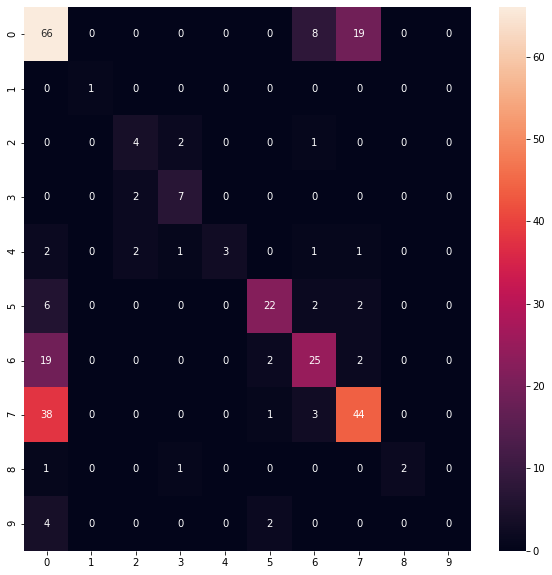

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

cf_matrix = confusion_matrix(y_test, ensemble_predict)

import seaborn as sns

sns.heatmap(cf_matrix, annot=True)

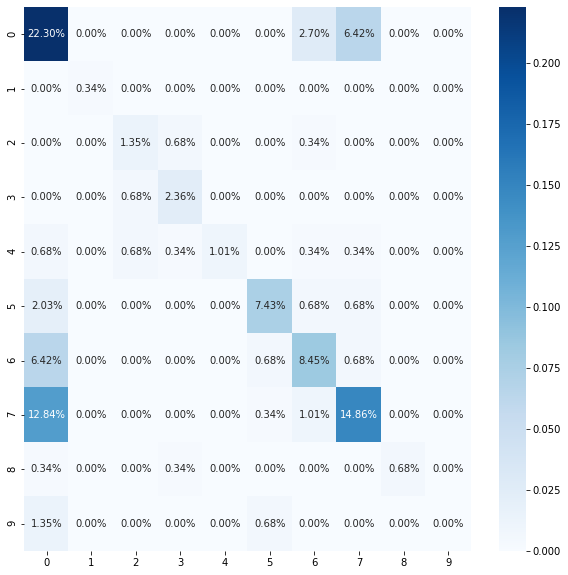

In [14]:
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [15]:
print(classification_report(y_test,ensemble_predict))

              precision    recall  f1-score   support

         CYT       0.49      0.71      0.58        93
         ERL       1.00      1.00      1.00         1
         EXC       0.50      0.57      0.53         7
         ME1       0.64      0.78      0.70         9
         ME2       1.00      0.30      0.46        10
         ME3       0.81      0.69      0.75        32
         MIT       0.62      0.52      0.57        48
         NUC       0.65      0.51      0.57        86
         POX       1.00      0.50      0.67         4
         VAC       0.00      0.00      0.00         6

    accuracy                           0.59       296
   macro avg       0.67      0.56      0.58       296
weighted avg       0.61      0.59      0.58       296



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
